### Simulating the effect of 1/f slope change on ERPs
April 18, 2018

In [265]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# import sys
# sys.path.append('/Users/rdgao/Documents/code/research/spectralCV/')
# sys.path.append('/Users/rdgao/Documents/code/research/neurodsp/')

# imports
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# import neurodsp as ndsp
# from scv_funcs import lfpca
# from scv_funcs import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [266]:
def grab_window(data, ind, left=0, right=50):
    return data[int(ind-left):int(ind+right)]

def rotate_powerlaw(data, fs, delta_f, f_rotation=30):
    # compute FFT and frequency axis
    FC = np.fft.fft(data)
    f_axis = np.fft.fftfreq(len(data), 1./fs)
    
    # make the 1/f mask
    f_mask = np.zeros_like(f_axis)
    f_mask[1:] = 10**(np.log10(np.abs(f_axis[1:]))*delta_f)
    f_mask[0]=1.
    
    # normalize power at rotation frequency
    f_mask = f_mask/f_mask[np.where(f_axis>=f_rotation)[0][0]]
    
    return np.real(np.fft.ifft(FC*f_mask))

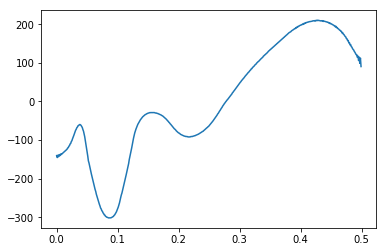

In [267]:
# grab the ERP
image = sp.misc.imread('ERP_wave.png').mean(axis=2)
ERP_raw = np.argmax(image, axis=0)[:800]
ERP = sp.signal.resample(ERP,510)[8:-2]
ERP = ERP-np.mean(ERP)
plt.plot(np.arange(0,500)/fs,ERP)

Random Seed: 26
399 trials total.


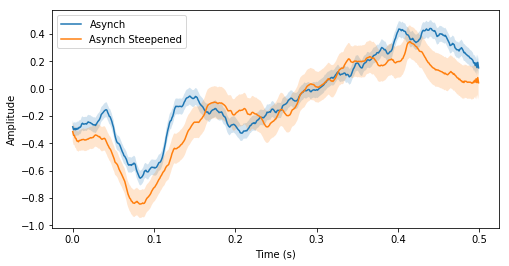

In [269]:
# simulating noise
seed = np.random.randint(0,100)
print('Random Seed: %i'%seed)
np.random.seed(seed)
identical_noise = False

# parameters
fs = 1000
T = 20*60 # total experiment time in seconds
stim_period = 3. # per trial length in seconds
trial_len = .5 # trial length to grab
norm_len = 0.1 # pre-stim baseline length
erp_amp = 0.002 # amplitude of ERP

tauR=0.002
tauD=0.02
syn_noise = ndsp.sim_synaptic_noise(T,fs,tauR=tauR,tauD=tauD)
syn_noise = sp.stats.zscore(syn_noise) # normalize amplitude
if identical_noise:
    # use the exact same noise, just rotated
    syn_noise_steep = rotate_powerlaw(syn_noise, fs, delta_f=-0.3, f_rotation=30) # 1/frotate noise
else:
    # re-simulate noise
    syn_noise_steep = ndsp.sim_synaptic_noise(T,fs,tauR=tauR,tauD=tauD)
    syn_noise_steep = sp.stats.zscore(syn_noise_steep)
    syn_noise_steep = rotate_powerlaw(syn_noise_steep, fs, delta_f=-0.3, f_rotation=30) # 1/frotate noise

# simulation stim times
stim_times = np.arange(stim_period,T,stim_period)
print("%i trials total."%len(stim_times))

# grab trials
t = np.arange(0,trial_len, 1/fs)
trialed = np.zeros((len(stim_times), int(trial_len*fs), 2))
for ind, st in enumerate(stim_times):
    trialed[ind, :, 0] = grab_window(syn_noise, st*fs, 0, trial_len*fs)-np.mean(grab_window(syn_noise,st*fs,norm_len*fs,0))+ERP*erp_amp
    trialed[ind, :, 1] = grab_window(syn_noise_steep, st*fs, 0, trial_len*fs)-np.mean(grab_window(syn_noise_steep,st*fs,norm_len*fs,0))+ERP*erp_amp
    
# plotting
M = np.mean(trialed,0) # mean
SE = np.std(trialed,0)/(len(stim_times)**0.5) # standard error
labels=('Asynch', 'Asynch Steepened')
plt.figure(figsize=(8,4))
for i in range(2):
    plt.plot(t,M[:,i], label=labels[i])
    plt.fill_between(t, M[:,i]-SE[:,i], M[:,i]+SE[:,i], alpha=0.2)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend();

### Take-Aways
- Rotating the 1/f clockwise around some knee (30Hz here) basically increases the low frequency power of the per-trial noise

- Doing so will always increases the overall variance (or standard error - orange band will always be thicker than blue band), but not necessarily the overall mean (ERP).

- The degree to which this effect shows up is a function of 
    - 1) the number of trials: the more trials we have, the more averaged out the noise will be. In the limit of infinite trials (practically, approaching 1000), the noise, by definition, will average out to 0, hence leaving the same ERP.
    - 2) the relative amplitude of the ERP (erp_amp): the higher the ERP amplitude, the less effect the noise will have.

- Effect is more or less the same when we use the exact same noise (identical_noise=True), just rotated. You can see that the underlying ERP is the almost same but the variance changes and some random part of the ERP will be deflected.


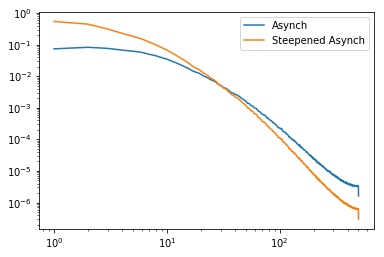

In [186]:
# plt.loglog(ndsp.spectral.psd(syn_noise, fs)[1], label='Asynch')
# plt.loglog(ndsp.spectral.psd(syn_noise_steep, fs)[1], label='Steepened Asynch')
# plt.legend()

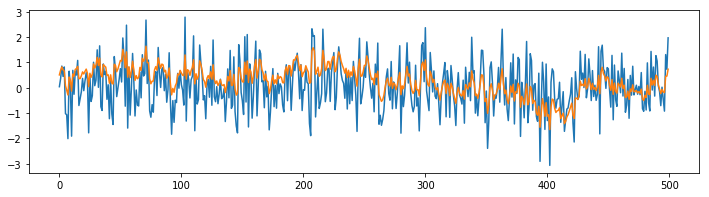

In [281]:
x = np.random.randn(100000)
x_s = rotate_powerlaw(x,1000,-0.50,20)
# plt.loglog(ndsp.spectral.psd(x, 1000)[1])
# plt.loglog(ndsp.spectral.psd(x_s, 1000)[1])
plt.figure(figsize=(12,3))
plt.plot(x[:500])
plt.plot(x_s[:500])